In [2]:
!pip install -q -U transformers
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

my_token="YOUR_HUGGING_FACE_TOKEN_HERE"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def change_object_color_by_name(image, mask, color_name="red", alpha=0.7):
    """
    Translates a text string like 'red' into RGB and applies it to the mask.
    """
    try:
        # 1. Convert text name (e.g., 'blue') to RGB tuple (0.0 to 1.0)
        rgb_float = mcolors.to_rgb(color_name)

        # 2. Convert to 0-255 scale for image processing
        target_rgb = [int(c * 255) for c in rgb_float]

    except ValueError:
        print(f"Color '{color_name}' not found. Defaulting to Red.")
        target_rgb = [255, 0, 0]

    # --- Standard Math Treatment (Non-AI) ---
    img_np = np.array(image).copy()
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
    mask = mask.astype(bool)

    for c in range(3):
        img_np[:, :, c] = np.where(
            mask,
            (img_np[:, :, c] * (1 - alpha) + target_rgb[c] * alpha).astype(np.uint8),
            img_np[:, :, c]
        )

    return Image.fromarray(img_np)

In [4]:
print(mcolors.CSS4_COLORS.keys())

dict_keys(['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lights

In [5]:
model_id = "facebook/sam3"
processor = Sam3Processor.from_pretrained(model_id,token=my_token)
model = Sam3Model.from_pretrained(model_id,token=my_token).to(device)

print("Models loaded and ready.")

processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Models loaded and ready.


In [6]:
raw_image = Image.open("/content/test2.jpg").convert("RGB")
# Input order
command = "change bottle blue" # @param {type:"string"}

In [7]:
def execute_recolor_command(user_cmd, image):
    # Basic parsing: "change [object] [color]"
    parts = user_cmd.lower().split()
    if len(parts) < 3: return print("Error: Command format must be 'change object color'")

    target_obj = parts[1]
    new_color = parts[2]
    # 1. Run SAM 3 to get the mask
    inputs_sam = processor(images=image, text=target_obj, return_tensors="pt").to(device)
    with torch.no_grad():
      outputs_sam = model(**inputs_sam)

    # 2. Extract Mask (using your provided call)
    results = processor.post_process_instance_segmentation(
        outputs_sam, threshold=0.5, target_sizes=[image.size[::-1]]
    )[0]

    if len(results['masks']) > 0:
            mask = results['masks'][0] # Take the first mask

            # 3. Apply your image treatment function (from your file)
            # result_img = change_object_color_by_name(image, mask, color_name=new_color, alpha=0.6)
            # (Assuming you run the function definition from your file first)
            result_img = change_object_color_by_name(image, mask, color_name=new_color, alpha=0.6)

            # 4. Feature: Save the binary mask as an image
            mask_np = (mask.cpu().numpy() * 255).astype(np.uint8)
            mask_image = Image.fromarray(mask_np)
            mask_image.save("object_mask.png")
            print("Binary mask saved as 'object_mask.png'")

            return result_img
    else:
            print(f"Command Rejected: The model did not find a '{target_obj}' in its analysis.")

Binary mask saved as 'object_mask.png'


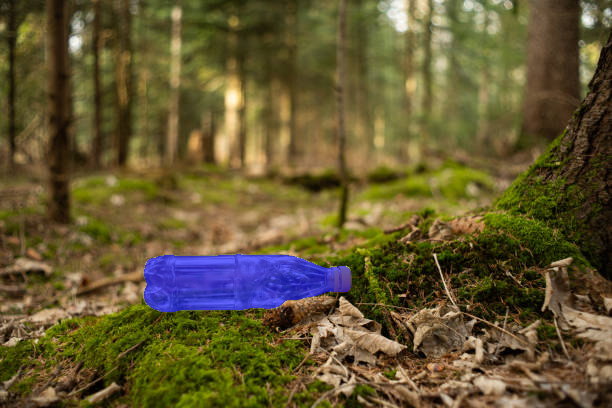

In [8]:
output_result = execute_recolor_command(command,raw_image)
if output_result:
    display(output_result)

Saved Binary Mask:


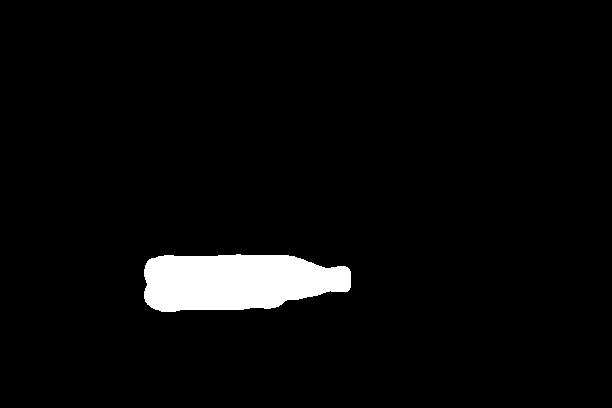

In [9]:
from IPython.display import display
saved_mask = Image.open("object_mask.png")
print("Saved Binary Mask:")
display(saved_mask)